In [ ]:
# download the required dataset from kaggle 

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d bharatsahu/speech-commands-classification-dataset

100% 1.37G/1.38G [00:19<00:00, 94.4MB/s]
100% 1.38G/1.38G [00:19<00:00, 77.8MB/s]


In [ ]:
!unzip /content/speech-commands-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: wow/d9d6559e_nohash_0.wav  
  inflating: wow/d9d6559e_nohash_1.wav  
  inflating: wow/da4ef063_nohash_0.wav  
  inflating: wow/da584bc0_nohash_0.wav  
  inflating: wow/da5dadb9_nohash_0.wav  
  inflating: wow/da76aa58_nohash_0.wav  
  inflating: wow/da76aa58_nohash_1.wav  
  inflating: wow/da76aa58_nohash_2.wav  
  inflating: wow/dabf67d9_nohash_0.wav  
  inflating: wow/dabf67d9_nohash_1.wav  
  inflating: wow/dabf67d9_nohash_2.wav  
  inflating: wow/daf230ac_nohash_0.wav  
  inflating: wow/db43cd03_nohash_0.wav  
  inflating: wow/db72a474_nohash_0.wav  
  inflating: wow/db79a764_nohash_0.wav  
  inflating: wow/db7c95b0_nohash_0.wav  
  inflating: wow/db9cd41d_nohash_0.wav  
  inflating: wow/dbaf8fc6_nohash_0.wav  
  inflating: wow/dbaf8fc6_nohash_1.wav  
  inflating: wow/dbb40d24_nohash_0.wav  
  inflating: wow/dc2222d7_nohash_0.wav  
  inflating: wow/dc269564_nohash_0.wav  
  inflating: wow/dc6e9c04_nohash_0.wav  
  infl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import os, random, librosa
from tqdm.auto import tqdm
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

In [ ]:
class config:
    CLASSES = np.array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
                        'bed','bird','cat','dog','down','go','happy','house','left','marvin','no'
                        ,'off','on','right','sheila','stop','tree','up','wow','yes'])
    MAX_EPOCHS = 500


# Data Preparation
These audio files are 1 sec long and have a sample rate 16000 ie the audio is sampled 16000 times per second. `read_and_pad_sound_wave` function readds the sound file and ensures the length of the file is consistent (1sec in this case) and returns the signal along with its sample rate

We'll convert the waveform into a mel spectrogram, which shows frequency changes over time and can be represented as a 2D image, which will be used as an input to the CNN, `sound_wave_to_mel_spectrogram` converts an audio into a mel spectrogram of the required dimesnsions


In [ ]:
def read_and_pad_sound_wave(filepath, audio_length=16000):
    waveform, sr = sf.read(filepath)
    zero_padding = np.zeros([audio_length - len(waveform)])
    waveform = np.concatenate([waveform, zero_padding], 0)
    return waveform, sr

def sound_wave_to_mel_spectrogram(sound_wave, sample_rate, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sample_rate * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sample_rate, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

class_distribution = []
spectrogram_samples = []
audio_samples = []

ROOT = '/content'
DATA = 'mel_spectrograms'
if not os.path.exists(DATA):
    os.mkdir(DATA)
      
for label in tqdm(config.CLASSES):
    src_dir = os.path.join(ROOT, label)
    dst_dir = os.path.join(DATA, label)
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
        
    for i, filename in enumerate(os.listdir(src_dir)[:1500]):
        class_distribution.append(label)
        src_path = os.path.join(src_dir, filename)
        dst_path = f"{os.path.join(dst_dir, filename[:-4])}.png"
        plt.imsave(dst_path, sound_wave_to_mel_spectrogram(*read_and_pad_sound_wave(src_path)), cmap='gray')
        if i == 0:
            spectrogram_samples.append(dst_path)
            audio_samples.append(src_path)
print('done')    

  0%|          | 0/30 [00:00<?, ?it/s]

done


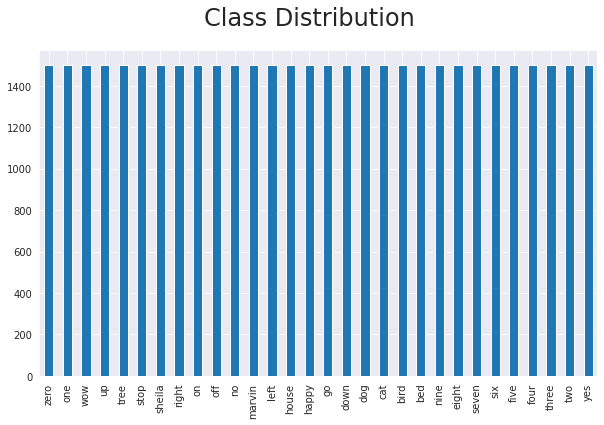

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.Series(class_distribution).value_counts().plot.bar()
fig.suptitle('Class Distribution', fontsize=24);

# Sample Audio

In [ ]:
for i in range(len(config.CLASSES)):
    display.display(display.Audio(read_and_pad_sound_wave(audio_samples[i])[0], rate=16000))

In [ ]:
for i in range(len(config.CLASSES)):
    fig, ax = plt.subplots(1,2, figsize=(20, 4))
    ax[0].plot(read_and_pad_sound_wave(audio_samples[i])[0])
    ax[1].imshow(plt.imread(spectrogram_samples[i]), cmap='gray')
    fig.suptitle(config.CLASSES[i], fontsize=15);

# Data Generator

In [ ]:
image_size = (128, 128, 1)
datagen = ImageDataGenerator(validation_split=0.1)

training_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='training'
)
validation_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='validation'
)

Found 40500 images belonging to 30 classes.
Found 4500 images belonging to 30 classes.


In [ ]:
x,y=validation_set.next()

In [ ]:
x.shape

(32, 128, 128, 1)

# Modellling

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=image_size, padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),  
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),   
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(config.CLASSES), activation='softmax'),
])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 conv2d_35 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, 3, input_shape=image_size, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    layers.MaxPooling2D(padding='same'),
     layers.Dropout(0.25),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    layers.MaxPooling2D(padding='same'),
         layers.Dropout(0.25),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    layers.MaxPooling2D(padding='same'),
             layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(len(config.CLASSES), activation='softmax'),
])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_22 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_22 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 conv2d_43 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_23 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_23 (Activation)  (None, 128, 128, 32)     

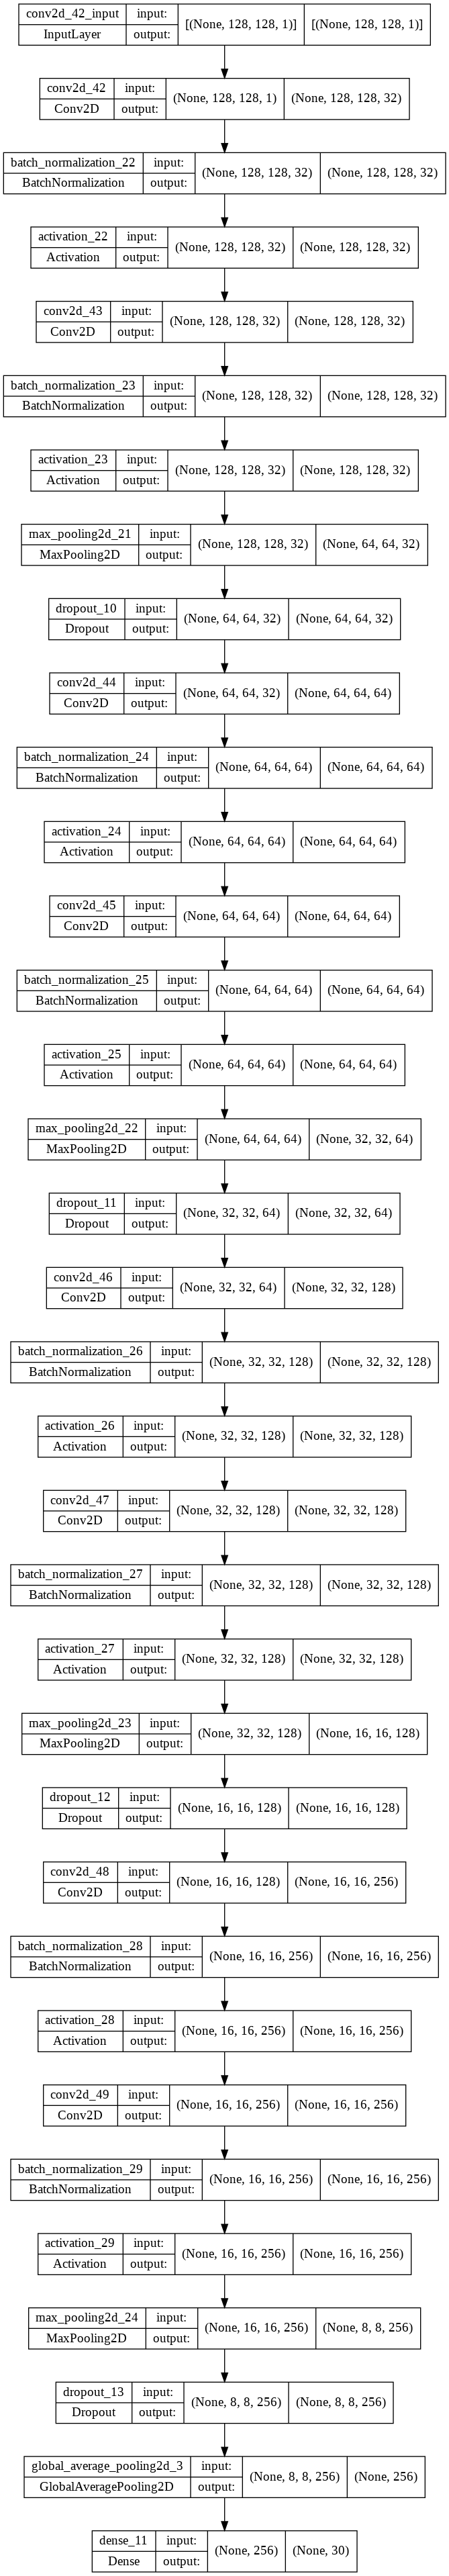

In [ ]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])
# save the best model based on the validation loss
save_best_model_collback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/model", save_best_only=True
)

In [ ]:
model.fit(training_set,validation_data=(validation_set),epochs=100, callbacks=[save_best_model_collback])

Epoch 1/100
  75/1266 [>.............................] - ETA: 1:10 - loss: 0.0387 - acc: 0.9883

KeyboardInterrupt: ignored

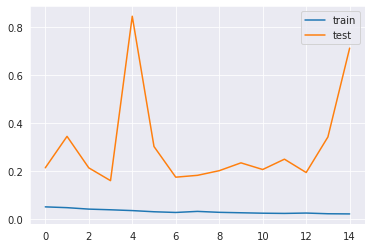

In [ ]:
## plot the overfitting
plt.plot(model.history.history['loss'],label='train')
plt.plot(model.history.history['val_loss'],label='test')
plt.legend()
plt.show()


In [ ]:
loss,acc=model.evaluate(validation_set,verbose=2)

141/141 - 4s - loss: 0.2029 - acc: 0.9487 - 4s/epoch - 32ms/step


##check the test in prediction

In [ ]:
CLASSES=['bed','bird','cat','dog','down','eight','five','four','go','happy','house','left','marvin',
         'nine','no','off','on','one','right','seven','sheila','six','stop','three','tree'
         ,'two','up','wow','yes','zero']

In [ ]:
x_test,y_test =validation_set.next()

In [ ]:
x_test.shape,y_test.shape

((32, 128, 128, 1), (32, 30))

In [ ]:
y_true=tf.argmax(y_test,axis=-1).numpy()
for i in y_true:
    print(CLASSES[i],end=" , ")

eight , up , happy , off , four , six , one , left , yes , on , bird , five , eight , dog , zero , left , on , bird , five , three , three , stop , bed , yes , three , three , no , no , one , go , yes , house , 

In [ ]:
pred=tf.argmax(model.predict(x_test),axis=-1).numpy()
for n in pred:
    print(CLASSES[n] , end=" , ")

eight , up , happy , off , four , six , one , left , yes , on , bird , five , eight , dog , zero , left , on , bird , five , three , tree , stop , bed , yes , three , three , no , no , one , go , six , house , 

# Display a confusion matrix

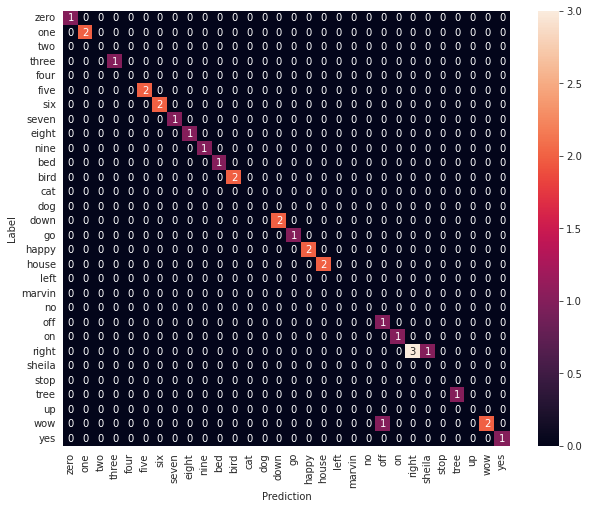

In [ ]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=config.CLASSES,
            yticklabels=config.CLASSES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model = tf.keras.models.load_model(filepath="/content/model")


KeyboardInterrupt: ignored

In [ ]:
model.save('speech_comand_model.h5')

NameError: ignored

# Load the model

In [ ]:
model = tf.keras.models.load_model('speech_comand_model_acc96.h5')

In [ ]:
loss,acc=model.evaluate(validation_set,verbose=2)

141/141 - 6s - loss: 0.1450 - acc: 0.9649 - 6s/epoch - 41ms/step


# check test in prediction

In [ ]:
x_test,y_test =validation_set.next()

In [ ]:
y_true=tf.argmax(y_test,axis=-1).numpy()
for i in y_true:
    print(CLASSES[i],end=" , ")

eight , up , happy , off , four , six , one , left , yes , on , bird , five , eight , dog , zero , left , on , bird , five , three , three , stop , bed , yes , three , three , no , no , one , go , yes , house , 

In [ ]:
pred=tf.argmax(model.predict(x_test),axis=-1).numpy()
for n in pred:
    print(CLASSES[n] , end=" , ")

eight , up , happy , off , four , six , one , left , yes , on , bird , five , eight , dog , zero , left , on , bird , five , three , three , stop , bed , yes , three , three , no , no , one , go , yes , house , 

# Display a confusion matrix

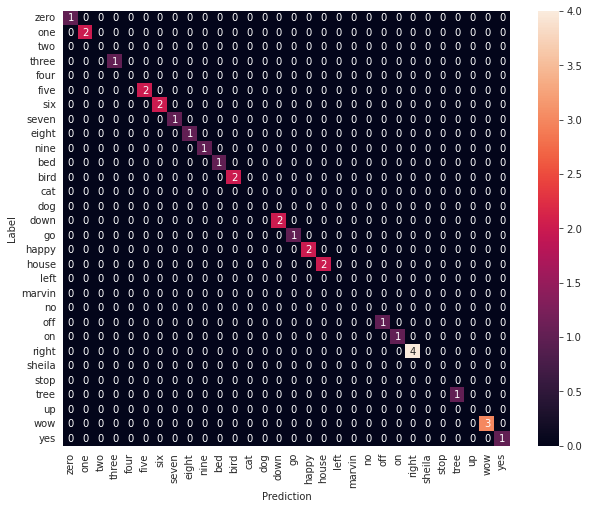

In [ ]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=config.CLASSES,
            yticklabels=config.CLASSES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Gradio prediction


In [ ]:
!pip install gradio
from google.colab import output
output.clear()

In [ ]:
import gradio as gr
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input


In [ ]:
def read_and_pad_sound_w(filepath, audio_length=16000):
    waveform, sr = sf.read(filepath)
    zero_padding = np.zeros([audio_length - len(waveform)])
    waveform = np.concatenate([waveform, zero_padding], 0)
    return waveform, sr

In [ ]:

  
def read_and_pad_sound_wave(audio, audio_length=16000):
    sr, waveform = audio
    print(sr)
    trimmed_audio=waveform/np.max(waveform)
    trimmed_audio=librosa.resample(trimmed_audio,sr,16000)

    trimmed_audio,sample_trimmed=librosa.effects.trim(trimmed_audio,top_db=36.3)
    sr=16000
    if len(trimmed_audio)<sr :
        zero_padding = np.zeros([sr - len(trimmed_audio)])
        trimmed_audio = np.concatenate([trimmed_audio, zero_padding], 0)
   
    elif len(trimmed_audio)>sr:
        trimmed_audio=trimmed_audio[-sr:]
    plt.plot(trimmed_audio)

    print(display.display(display.Audio(trimmed_audio, rate=16000)))
    return trimmed_audio, 16000

def sound_wave_to_mel_spectrogram(sound_wave, sample_rate, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sample_rate * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sample_rate, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def get_gradio(audio):
    spectrogram_samples = []
    DATA = 'gradio_spectrograms'
    if not os.path.exists(DATA):
        os.mkdir(DATA)
  
    dst_dir = DATA
    dst_path = f"{os.path.join(dst_dir, '101')}.png"

    plt.imsave(dst_path, sound_wave_to_mel_spectrogram(*read_and_pad_sound_wave(audio)), cmap='gray')
   

    spectrogram_samples.append(dst_path)


    wav,b=read_and_pad_sound_wave(audio)


    my_image = load_img(spectrogram_samples[0], target_size=(128, 128),color_mode="grayscale")

    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))

    my_image.shape
    x=my_image
    pred=tf.argmax(model.predict(x),axis=-1).numpy()
    for n in pred:
        print(CLASSES[n] , end=" , ")
    return CLASSES[n]
  

In [ ]:
dicte={'Happy':"/content/happy/01b4757a_nohash_0.wav",
       'down': '/content/down/00176480_nohash_0.wav',
        'right':'/content/right/00b01445_nohash_0.wav'}

In [ ]:
descripe=" you can talking one of these words   \n house , left , marvin , nine , no , off , on , one , right , seven , \n bed , bird , cat , dog , down , eight , five , four , go , happy  , \n sheila , six , stop , three , tree , two , up , wow , yes , zero "

/usr/local/lib/python3.7/dist-packages/gradio/interface.py:328: UserWarning: Currently, only the 'default' theme is supported.
  warnings.warn("Currently, only the 'default' theme is supported.")


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://27810.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


48000


None
48000


None
three , 48000


None
48000


None
off , 48000


None
48000


None
four , 48000


None
48000


None
cat , 48000


None
48000


None
six , 16000


None
16000


None
down , 16000


None
16000


None
right , Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fb7df053d10>,
 'http://127.0.0.1:7860/',
 'https://27810.gradio.app')

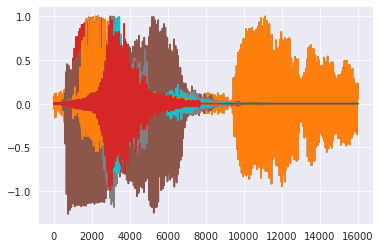

In [ ]:
iface = gr.Interface(fn=get_gradio , inputs=gr.Audio(source="microphone" ), 
                     outputs='text',
                     title='Speech Recognetion',description ='AI model to transform voice to text',
                     theme='theme',article=descripe,

                     thumbnail=[dicte['down']]
                     , examples=[dicte['Happy'], dicte['down'],dicte['right']]
                     )

iface.launch(debug=True)